## Notebook to pilot using DroneDetect Data to detect presence of Drones
- load data
- generate features - PSD, spectrogram
- test on SVM classifier
- test CNN

In [1]:
import os
import numpy as np
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
import os
from sklearn.model_selection import train_test_split
from spafe.features.lfcc import lfcc
import spafe.utils.vis as vis
from scipy.signal import get_window
import scipy.fftpack as fft
from scipy import signal
import matplotlib.pyplot as plt

In [2]:
# Dataset Info
fs = 60e6 #60 MHz
bandwidth = 20e6 # 28MHz
center_freq = 2.43e9


In [3]:
# Data Location
main_folder = '/home/ltindall/data/DroneDetect/DroneDetect_V2/'
sub_folders = os.listdir(main_folder)




# file_names_h = os.listdir(data_folder+'High/')
# file_names_l = os.listdir(data_folder+'Low/')

# file_names_h.sort()
# file_names_l.sort()

In [4]:
sub_folders

['WIFI', 'BLUE', 'CLEAN', 'BOTH']

In [5]:
def load_data(file_path):
    f = open(file_path, "rb")                                        # open file
    data = np.fromfile(f, dtype="float32",count=240000000)      # read the data into numpy array
    data = data.astype(np.float32).view(np.complex64)           # view as complex
    data_norm = (data-np.mean(data))/(np.sqrt(np.var(data)))    # normalise
    newarr = np.array_split(data_norm, 100)	                    # split the array, 100 will equate to a sample length of 20ms
    return newarr, data_norm

In [6]:
# labels
DRONES = []
CONDS =[]
INTS = [] # interferences: 00 for a clean signal, 01 for Bluetooth only, 10 for Wi-Fi only and 11 for Bluetooth and Wi-Fi interference concurrently.

# features
F_PSD = []

# loop through all files
for sf in sub_folders:
    drone_folders = os.listdir(main_folder+sf+'/')
    for df in drone_folders:
        files = os.listdir(main_folder+sf+'/'+df+'/')
        for f in files:
            # save labels
            DRONES.append(df[:3])
            CONDS.append(df[4:])
            INTS.append(f[4:6])
            
            d_split, d_all = load_data(main_folder+sf+'/'+df+'/'+f)
            d_real = abs(d_all)
            
            # calculate PSD
            f, Pxx_den = signal.welch(d_real, fs, window='hamming', nperseg=1024)
            F_PSD.append(Pxx_den)
    

In [12]:
# CHOOSE FEATURES
Xs = F_PSD
ys = DRONES

# change lists to arrays and make it stackable
Xs_arr = np.array(Xs)
Xs_arr.shape

y_arr = np.array(ys)

In [13]:
N = Xs_arr.shape[0] # number of data points

## Visualize the signals

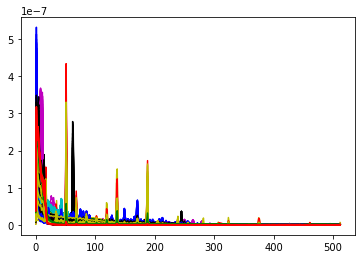

In [14]:
# plot for each type of drone
X_norm = Xs
for n in range(N):
    if DRONES[n] == 'AIR':
        c = 'r'
    elif DRONES[n] == 'DIS':
        c = 'b'
    elif DRONES[n] == 'INS':
        c = 'g'
    elif DRONES[n] == 'MIN':
        c = 'c'
    elif DRONES[n] == 'MP1':
        c = 'm'
    elif DRONES[n] == 'MP2':
        c = 'k'
    elif DRONES[n] == 'PHA':
        c = 'y'
    
    # normalize it
#     X_norm[n] = Xs[n]/max(Xs[n])
    plt.plot(Xs[n],color=c)

In [15]:
# F_PSD_4096 = F_PSD # saved this as a separate variable
# np.save('test_PSD_4096.txt', F_PSD_2096) 
np.save('test_PSD_1024.txt', F_PSD)

In [16]:
# select which Xs
Xs_arr = np.array(F_PSD)

In [268]:
Xs_arr.shape

(390, 513)

### Apply ML

In [17]:
# Train_test_split & one hot encode
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# split data into K-fold
k_fold = 10
cv = KFold(n_splits=k_fold, random_state=1, shuffle=True)

# model parameters
Cs=list(map(lambda x:pow(2,x),range(-15,16,2)))
gammas=list(map(lambda x:pow(2,x),range(-15,16,2)))


### SVM

In [18]:
best_params_ls = []
score_ls = []
parameters = {'C':Cs, 'gamma':gammas}
for train_ix, test_ix in cv.split(Xs_arr):
    
    # find the optimal hypber parameters
    svc = svm.SVC(kernel='rbf')
    clf = GridSearchCV(svc, parameters, n_jobs=1)
    clf.fit(Xs_arr[train_ix], y_arr[train_ix])
    
    print(clf.best_params_)
    best_params_ls.append(clf.best_params_)
    
    # predict on the test data
    y_pred = clf.predict(Xs_arr[test_ix])
    acc = accuracy_score(y_arr[test_ix], y_pred)
    print(acc)
    score_ls.append(acc)

{'C': 3.0517578125e-05, 'gamma': 0.001953125}
0.1794871794871795
{'C': 3.0517578125e-05, 'gamma': 0.00048828125}
0.1282051282051282
{'C': 3.0517578125e-05, 'gamma': 3.0517578125e-05}
0.07692307692307693
{'C': 3.0517578125e-05, 'gamma': 0.001953125}
0.3076923076923077
{'C': 3.0517578125e-05, 'gamma': 0.00048828125}
0.07692307692307693
{'C': 3.0517578125e-05, 'gamma': 0.001953125}
0.07692307692307693
{'C': 3.0517578125e-05, 'gamma': 3.0517578125e-05}
0.07692307692307693
{'C': 3.0517578125e-05, 'gamma': 3.0517578125e-05}
0.10256410256410256
{'C': 3.0517578125e-05, 'gamma': 3.0517578125e-05}
0.07692307692307693
{'C': 3.0517578125e-05, 'gamma': 3.0517578125e-05}
0.07692307692307693


In [100]:
print('SVM score is ', np.mean(score_ls))

SVM score is  0.9871794871794872


In [112]:
print('SVM score is ', np.mean(score_ls)) #not normalized


SVM score is  0.2230769230769231


### Logistic regression

In [116]:
from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(random_state=0).fit(Xs_arr[train_ix], ys_arr[train_ix])

In [123]:
best_params_ls = []
score_ls = []

parameters = {'C':[0.01,0.1,1,10,100,1000, 10000]}

for train_ix, test_ix in cv.split(Xs_arr):
    
    # find the optimal hypber parameters
    lr = LogisticRegression(max_iter=1000000)
    clf = GridSearchCV(lr, parameters, n_jobs=1)
    clf.fit(Xs_arr[train_ix], y_arr[train_ix])
    
    print(clf.best_params_)
    best_params_ls.append(clf.best_params_)
    
    # predict on the test data
    y_pred = clf.predict(Xs_arr[test_ix])
    acc = accuracy_score(y_arr[test_ix], y_pred)
    print(acc)
    score_ls.append(acc)

{'C': 100}
0.9743589743589743
{'C': 1000}
0.9743589743589743
{'C': 100}
0.9487179487179487
{'C': 100}
1.0
{'C': 1000}
1.0
{'C': 1000}
0.9743589743589743
{'C': 1000}
0.9743589743589743
{'C': 100}
0.9743589743589743
{'C': 100}
0.9743589743589743
{'C': 100}
1.0


In [124]:
print('LR score is ', np.mean(score_ls)) #not normalized


LR score is  0.9794871794871796


## CNN 

In [205]:
# import the necessary packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch
import torchvision.models as models

### Apply ResNet to get features

In [212]:
resnet50 = models.resnet50(pretrained=True)
modules=list(resnet50.children())[:-1]
# resnet50=nn.Sequential(*modules)
for p in resnet50.parameters():
    p.requires_grad = False

In [214]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 7)

resnet50 = resnet50.to(device)

In [260]:
input = torch.randn(batch_size, 1, 513) #(16,1,513)

# want shape (16,3,1,513)
input_rep = input.repeat(1,3,1)
input_rep = input_rep.reshape(batch_size, 3, 1, 513)
input_rep = input_rep.to(device)
print(input_rep.shape)
output = resnet50(input_rep)
output.shape

# images_pre = images.repeat(1, 3, 1)
# # images_pre = images_pre.reshape(batch_size, 3, 1, 513)
# print(images_pre.shape)  # (64, 224, 224, 3)

torch.Size([16, 3, 1, 513])


torch.Size([16, 7])

In [253]:
images.shape

torch.Size([6, 1, 513])

In [263]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    for epoch in range(num_epochs):
        #Load in the data in batches using the train_loader object
        for i, (images, labels) in enumerate(train_loader): 
            labels = labels.type(torch.long)
            images = input.repeat(1,3,1)
            images = input_rep.reshape(batch_size, 3, 1, 513)
#             print(images.shape)
#             images = images.reshape(batch_size, 3, 1, 513)
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    return model

In [266]:
optimizer_conv = torch.optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

resnet50 = train_model(resnet50, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch [1/10], Loss: 1.8944
Epoch [2/10], Loss: 1.9291
Epoch [3/10], Loss: 2.0450
Epoch [4/10], Loss: 1.9179
Epoch [5/10], Loss: 1.9906
Epoch [6/10], Loss: 1.9118
Epoch [7/10], Loss: 2.0229
Epoch [8/10], Loss: 1.9831
Epoch [9/10], Loss: 1.8981
Epoch [10/10], Loss: 1.9821


In [62]:
## Creating a custom dataset
class DroneDetectData(Dataset):
    def __init__(self, Xarr, yarr):
        self.Xarr = Xarr
        test_list=[]
        for ya in yarr:
            if ya == 'AIR':
                num= 1.
            if ya == 'DIS':
                num= 2.
            if ya == 'INS':
                num= 3.
            if ya == 'MIN':
                num= 4.
            if ya == 'MP1':
                num= 5.
            if ya == 'MP2':
                num= 6.
            if ya == 'PHA':
                num= 0.
            test_list.append(num)
        self.yarr = np.array(test_list)
        print(len(self.yarr))
        
    def __len__(self):
        return len(self.yarr)
    
    def __getitem__(self, index):
        # all data must be in float and tensor format
        X = torch.tensor((self.Xarr[index]))
        X = X.unsqueeze(0)
        y = torch.tensor(float(self.yarr[index]))
        return (X, y)
        
        

In [134]:
# define variables for ML task
# Hyperparameters
batch_size = 16 # the number of samples processed before the model is updated. (number of samples in the training data)
num_classes = 7
learning_rate = 0.001
num_epochs = 1000

# Device will determine whether to run the training on GPU or CPU.
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [135]:
# Setting up the data and dataloader
dataset = DroneDetectData(Xs_arr, ys_arr)
train_set, test_set = torch.utils.data.random_split(dataset, [224,140+26])

train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                           batch_size = batch_size,
                                           shuffle = True)

390


In [176]:
# tutorial: https://blog.paperspace.com/writing-cnns-from-scratch-in-pytorch/
# Creating a CNN class
class ConvNeuralNet(nn.Module):
    #  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv1d(1, 32, 100)
        self.maxpool1 = nn.AvgPool1d(kernel_size=1)
        self.conv2 = nn.Conv1d(32, 64, 3)
        self.conv3 = nn.Conv1d(64,128, 3)
        self.conv4 = nn.Conv1d(128, 128, 3)
#         self.dense = nn.Linear(64640, num_classes)
        self.dense = nn.Linear(13248, num_classes)
        
        
#         # an affine operation: y = Wx + b
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)
    
    # Progresses data across layers    
    def forward(self, x):
         # Max pooling over a (2, 2) window
        x = self.conv1(x)
        x = self.maxpool1(x)
#         print(x.shape)
#         x = self.conv2(x)
#         x = self.maxpool1(x)
#         x = self.conv3(x)
#         x = self.maxpool1(x)
#         x = self.conv4(x)
#         x = self.maxpool1(x)
        x = nn.Dropout(p=0.25)(x)
        x = torch.flatten(x,1)
#         print(x.shape)
        x = self.dense(x)
#         print(x.shape)
#         x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
#         # If the size is a square, you can specify with a single number
#         x = F.max_pool2d(F.relu(self.conv2(x)), 2)
#         x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
        return x

In [177]:
# Try a random 32 x 32 input. 
input = torch.randn(batch_size, 1, 513)
# input_1d = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype = torch.float)

net = ConvNeuralNet(7)
out = net(input)
print(input.shape)
print(out.shape)

torch.Size([16, 1, 513])
torch.Size([16, 7])


In [178]:
model = ConvNeuralNet(num_classes)
model = model.to(device)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

total_step = len(train_loader)

In [179]:
# Training
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
    #Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader): 
        labels = labels.type(torch.long)

        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if i%10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

            
            

Epoch [1/1000], Loss: 1.9275
Epoch [2/1000], Loss: 1.9091
Epoch [3/1000], Loss: 1.8947
Epoch [4/1000], Loss: 2.0166
Epoch [5/1000], Loss: 1.9516
Epoch [6/1000], Loss: 1.9876
Epoch [7/1000], Loss: 1.8976
Epoch [8/1000], Loss: 1.8953
Epoch [9/1000], Loss: 1.9854
Epoch [10/1000], Loss: 1.9042
Epoch [11/1000], Loss: 1.8994
Epoch [12/1000], Loss: 1.9806
Epoch [13/1000], Loss: 1.8931
Epoch [14/1000], Loss: 1.8917
Epoch [15/1000], Loss: 1.9284
Epoch [16/1000], Loss: 1.9350
Epoch [17/1000], Loss: 1.8977
Epoch [18/1000], Loss: 1.8405
Epoch [19/1000], Loss: 1.9836
Epoch [20/1000], Loss: 1.9846
Epoch [21/1000], Loss: 1.9936
Epoch [22/1000], Loss: 2.0114
Epoch [23/1000], Loss: 1.9296
Epoch [24/1000], Loss: 1.9097
Epoch [25/1000], Loss: 1.8463
Epoch [26/1000], Loss: 1.9125
Epoch [27/1000], Loss: 1.9523
Epoch [28/1000], Loss: 1.9426
Epoch [29/1000], Loss: 1.9215
Epoch [30/1000], Loss: 1.9343
Epoch [31/1000], Loss: 1.9058
Epoch [32/1000], Loss: 1.9177
Epoch [33/1000], Loss: 1.8809
Epoch [34/1000], Lo

Epoch [271/1000], Loss: 1.9753
Epoch [272/1000], Loss: 1.8475
Epoch [273/1000], Loss: 1.9176
Epoch [274/1000], Loss: 1.9444
Epoch [275/1000], Loss: 1.9215
Epoch [276/1000], Loss: 1.9922
Epoch [277/1000], Loss: 1.8809
Epoch [278/1000], Loss: 1.9902
Epoch [279/1000], Loss: 1.9005
Epoch [280/1000], Loss: 1.9068
Epoch [281/1000], Loss: 1.8673
Epoch [282/1000], Loss: 1.9083
Epoch [283/1000], Loss: 1.8859
Epoch [284/1000], Loss: 1.8657
Epoch [285/1000], Loss: 1.9366
Epoch [286/1000], Loss: 1.9748
Epoch [287/1000], Loss: 1.9862
Epoch [288/1000], Loss: 1.8622
Epoch [289/1000], Loss: 1.8790
Epoch [290/1000], Loss: 1.8877
Epoch [291/1000], Loss: 1.9095
Epoch [292/1000], Loss: 1.8938
Epoch [293/1000], Loss: 1.8892
Epoch [294/1000], Loss: 1.9210
Epoch [295/1000], Loss: 1.9005
Epoch [296/1000], Loss: 1.8438
Epoch [297/1000], Loss: 1.9464
Epoch [298/1000], Loss: 1.9160
Epoch [299/1000], Loss: 1.9620
Epoch [300/1000], Loss: 1.8952
Epoch [301/1000], Loss: 1.8683
Epoch [302/1000], Loss: 1.9664
Epoch [3

Epoch [541/1000], Loss: 1.9501
Epoch [542/1000], Loss: 1.9156
Epoch [543/1000], Loss: 1.9224
Epoch [544/1000], Loss: 2.0166
Epoch [545/1000], Loss: 1.9355
Epoch [546/1000], Loss: 1.9313
Epoch [547/1000], Loss: 1.9491
Epoch [548/1000], Loss: 1.9958
Epoch [549/1000], Loss: 1.9281
Epoch [550/1000], Loss: 1.8838
Epoch [551/1000], Loss: 1.9830
Epoch [552/1000], Loss: 2.0039
Epoch [553/1000], Loss: 1.9233
Epoch [554/1000], Loss: 1.9473
Epoch [555/1000], Loss: 1.9410
Epoch [556/1000], Loss: 1.9747
Epoch [557/1000], Loss: 1.9575
Epoch [558/1000], Loss: 1.9262
Epoch [559/1000], Loss: 1.8903
Epoch [560/1000], Loss: 1.9371
Epoch [561/1000], Loss: 1.9851
Epoch [562/1000], Loss: 1.9684
Epoch [563/1000], Loss: 1.9310
Epoch [564/1000], Loss: 1.9143
Epoch [565/1000], Loss: 1.9689
Epoch [566/1000], Loss: 1.9328
Epoch [567/1000], Loss: 1.8566
Epoch [568/1000], Loss: 1.9873
Epoch [569/1000], Loss: 1.8492
Epoch [570/1000], Loss: 1.8920
Epoch [571/1000], Loss: 2.0242
Epoch [572/1000], Loss: 1.9844
Epoch [5

Epoch [810/1000], Loss: 1.8459
Epoch [811/1000], Loss: 1.9867
Epoch [812/1000], Loss: 1.9461
Epoch [813/1000], Loss: 1.8599
Epoch [814/1000], Loss: 1.9496
Epoch [815/1000], Loss: 1.8976
Epoch [816/1000], Loss: 1.9058
Epoch [817/1000], Loss: 1.9127
Epoch [818/1000], Loss: 2.0335
Epoch [819/1000], Loss: 1.8634
Epoch [820/1000], Loss: 1.9034
Epoch [821/1000], Loss: 1.8607
Epoch [822/1000], Loss: 2.0191
Epoch [823/1000], Loss: 1.9143
Epoch [824/1000], Loss: 1.9449
Epoch [825/1000], Loss: 1.9677
Epoch [826/1000], Loss: 2.0121
Epoch [827/1000], Loss: 1.8756
Epoch [828/1000], Loss: 1.9485
Epoch [829/1000], Loss: 1.9315
Epoch [830/1000], Loss: 1.8490
Epoch [831/1000], Loss: 1.8838
Epoch [832/1000], Loss: 1.8746
Epoch [833/1000], Loss: 1.9066
Epoch [834/1000], Loss: 1.9251
Epoch [835/1000], Loss: 1.9551
Epoch [836/1000], Loss: 1.9764
Epoch [837/1000], Loss: 1.9121
Epoch [838/1000], Loss: 1.8715
Epoch [839/1000], Loss: 2.0117
Epoch [840/1000], Loss: 1.9677
Epoch [841/1000], Loss: 1.9655
Epoch [8

In [268]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        images = images.repeat(1,3,1)
        images = images.reshape(batch_size, 3, 1, 513)
        outputs = resnet50(images)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} train images: {} %'.format(total, 100 * correct / total))



tensor([6, 4, 6, 4, 3, 3, 3, 3, 5, 3, 6, 6, 3, 6, 3, 3], device='cuda:0')
tensor([3, 3, 6, 6, 3, 3, 6, 3, 3, 3, 6, 6, 6, 3, 1, 3], device='cuda:0')
tensor([3, 6, 3, 6, 6, 3, 3, 6, 6, 3, 3, 6, 3, 3, 3, 3], device='cuda:0')
tensor([6, 6, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 6], device='cuda:0')
tensor([3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 6, 3, 3, 3], device='cuda:0')
tensor([3, 6, 6, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 4, 6], device='cuda:0')
tensor([3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 3, 6, 3, 3, 6, 6], device='cuda:0')
tensor([3, 6, 6, 3, 3, 6, 3, 5, 3, 3, 3, 3, 3, 6, 3, 1], device='cuda:0')
tensor([3, 3, 3, 3, 6, 6, 6, 3, 3, 3, 3, 3, 3, 6, 3, 3], device='cuda:0')
tensor([3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 6, 3, 3, 3, 3], device='cuda:0')


RuntimeError: shape '[16, 3, 1, 513]' is invalid for input of size 9234

In [269]:
images.shape

torch.Size([6, 3, 513])

In [193]:
outputs.data

tensor([[-0.1763,  0.0214, -0.3851,  0.1714,  0.2880,  0.0851,  0.0151],
        [-0.1781,  0.0115, -0.3900,  0.1637,  0.2939,  0.0860,  0.0188],
        [-0.1887,  0.0141, -0.3896,  0.1743,  0.2953,  0.0882,  0.0227],
        [-0.1751,  0.0180, -0.3895,  0.1623,  0.2914,  0.0828,  0.0256],
        [-0.1813,  0.0228, -0.3869,  0.1676,  0.2901,  0.0832,  0.0206],
        [-0.1824,  0.0154, -0.3881,  0.1726,  0.2853,  0.0934,  0.0264]],
       device='cuda:0')

In [191]:
labels.shape

torch.Size([16])

In [143]:
torch.max(outputs.data, 1)

torch.return_types.max(
values=tensor([0.2899, 0.2922, 0.2928, 0.2899, 0.2914, 0.2935], device='cuda:0'),
indices=tensor([4, 4, 4, 4, 4, 4], device='cuda:0'))

In [164]:
labels.shape

torch.Size([16])

In [167]:
predicted

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')

In [146]:
images.shape

torch.Size([6, 1, 513])

In [149]:
batch_size

16